## Importando as libs

In [51]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import (auc,roc_curve, recall_score, classification_report
                             precision_recall_fscore_support,roc_auc_score)

from sklearn.neural_network import MLPClassifier
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
RANDOM_SEED=333 #metade do número da besta

## Carregando o arquivo principal

In [7]:
dados_X = pd.read_csv('dados/orange_small_train.data',sep='\t')
#Headers = None pois a primeira linha já é registro válido
churn_labels = pd.read_csv('dados/labels/orange_small_train_churn.labels',sep='\t', header=None)
appetency_labels = pd.read_csv('dados/labels/orange_small_train_appetency.labels',sep='\t', header=None)
upselling_labels = pd.read_csv('dados/labels/orange_small_train_upselling.labels',sep='\t', header=None)
print(f'Registros em dados_X: {dados_X.shape[0]}\nRegistros em churn_labels: {churn_labels.shape[0]} \
\nRegistros em appetency_labels: {appetency_labels.shape[0]}\nRegistros em upselling_labels: {upselling_labels.shape[0]}')

Registros em dados_X: 50000
Registros em churn_labels: 50000 
Registros em appetency_labels: 50000
Registros em upselling_labels: 50000


In [102]:
dados_X.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.0,50000.000000,5.000000e+04,...,5.000000e+04,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,6.809496,0.0,48.145299,3.926057e+05,...,3.776755e+06,0.611456,1.416638e+06,7.777380e+04,8.460919,0.0,3.299145,16.544160,167.368477,270.142137
std,4.820354,0.022352,672.206258,0.226593,1.110451e+05,2532.849475,5.965363,0.0,18.326822,1.599995e+05,...,4.482539e+05,2.367372,4.050112e+05,3.175127e+04,7.397512,0.0,1.039849,7.130844,17.949779,56.221658
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,-6.420000,6.000000
25%,11.487179,0.004029,425.298387,0.125396,2.387933e+05,581.000000,0.000000,0.0,48.145299,3.926057e+05,...,3.776755e+06,0.000000,1.416638e+06,7.777380e+04,8.460919,0.0,3.299145,16.544160,167.368477,270.142137
50%,11.487179,0.004029,425.298387,0.125396,2.387933e+05,945.000000,7.000000,0.0,48.145299,3.926057e+05,...,3.776755e+06,0.000000,1.416638e+06,7.777380e+04,8.460919,0.0,3.299145,16.544160,167.368477,270.142137
75%,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,7.000000,0.0,48.145299,3.926057e+05,...,3.776755e+06,0.000000,1.416638e+06,7.777380e+04,8.460919,0.0,3.299145,16.544160,167.368477,270.142137
max,680.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,140.000000,0.0,2300.000000,1.232559e+07,...,1.428483e+07,49.000000,1.199478e+07,3.048400e+06,1200.000000,0.0,102.000000,910.000000,628.620000,642.000000


## Transformando o sim e não dos labels (estão -1 e 1)

In [103]:
churn_labels[0].value_counts()

-1    46328
 1     3672
Name: 0, dtype: int64

In [8]:
churn = churn_labels.ix[:, 0].astype('category')
churn.cat.rename_categories([0, 1], inplace=True)
appetency = appetency_labels.ix[:, 0].astype('category')
appetency.cat.rename_categories([0, 1], inplace=True)
upselling = upselling_labels.ix[:, 0].astype('category')
upselling.cat.rename_categories([0, 1], inplace=True)
churn.value_counts()

0    46328
1     3672
Name: 0, dtype: int64

## Proporção de 0 e 1

Text(0, 0.5, 'churn')

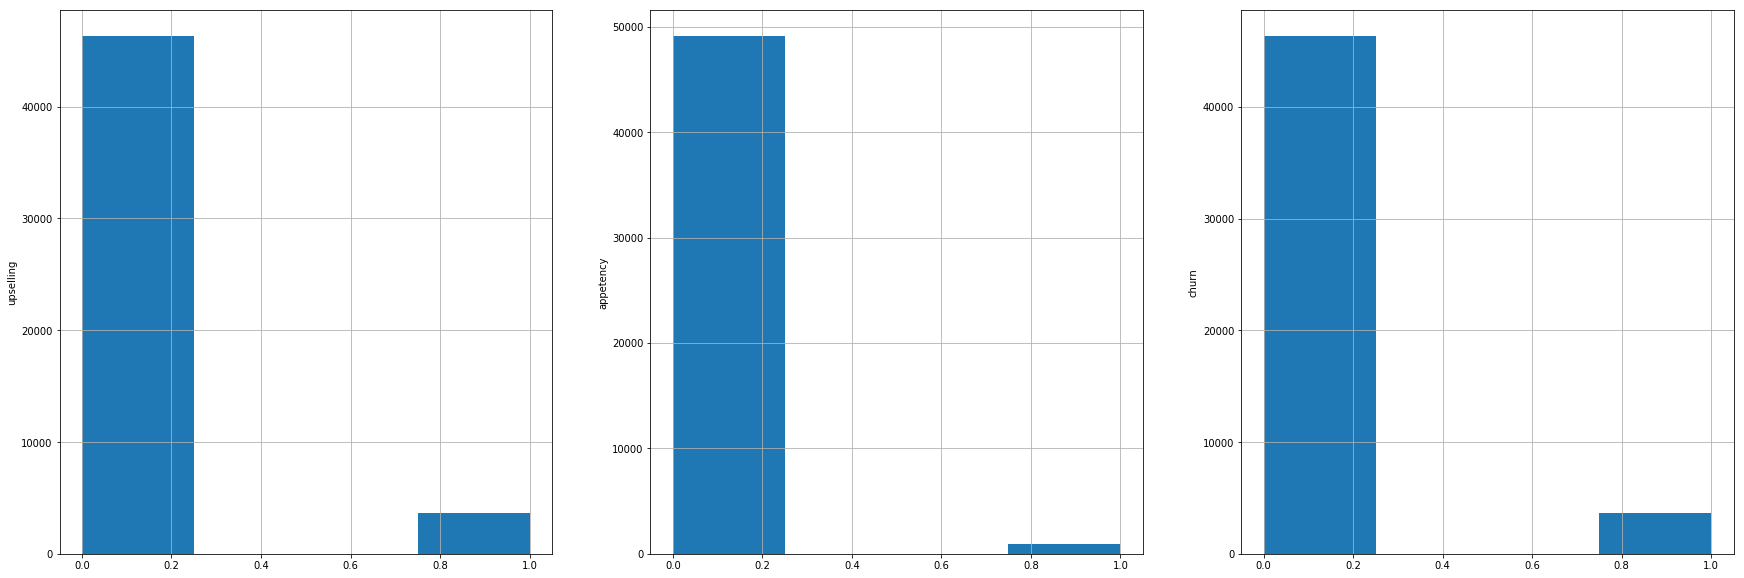

In [93]:
dados_plotar = pd.concat([churn,appetency,upselling], axis=1)
dados_plotar.columns = ['churn','appetency','upselling']
fig = plt.figure(figsize=(30, 10))

plt.subplot(131)
ax0 = dados_plotar['upselling'].hist(bins=4)
ax0.set_ylabel('upselling')

plt.subplot(132)
ax1 = dados_plotar['appetency'].hist(bins=4)
ax1.set_ylabel('appetency')

plt.subplot(133)
ax2= dados_plotar['churn'].hist(bins=4)
ax2.set_ylabel('churn')

## O Gap entre os valores é muito alto, será realizado um resample

Tratamento das colunas category

In [9]:
colunas_objetos = dados_X.select_dtypes(include=['object']).columns
dados_X[colunas_objetos] = dados_X[colunas_objetos].astype('category').apply(lambda x: x.cat.codes)
dados_X.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
count,702.000000,1241.000000,1240.000000,1579.000000,1.487000e+03,44471.000000,44461.000000,0.0,702.000000,1.487000e+03,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,0.0
mean,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,6.809496,NaN,48.145299,3.926057e+05,...,3.984080,2123.702060,0.302480,-0.983600,-0.220100,10.115720,2.103060,10.233400,-0.368800,NaN
std,40.709951,0.141933,4270.193518,1.275481,6.441259e+05,2685.693668,6.326053,NaN,154.777855,9.280896e+05,...,1.119166,1183.541455,1.070238,0.127009,0.933506,5.798438,0.867994,6.488254,0.799074,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,518.000000,0.000000,NaN,4.000000,0.000000e+00,...,4.000000,1066.000000,0.000000,-1.000000,-1.000000,6.000000,2.000000,8.000000,-1.000000,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,861.000000,7.000000,NaN,20.000000,0.000000e+00,...,4.000000,2230.000000,0.000000,-1.000000,-1.000000,10.000000,2.000000,8.000000,-1.000000,NaN
75%,16.000000,0.000000,0.000000,0.000000,1.187425e+05,1428.000000,7.000000,NaN,46.000000,2.628630e+05,...,4.000000,2984.250000,0.000000,-1.000000,1.000000,14.000000,2.000000,8.000000,0.000000,NaN
max,680.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,140.000000,NaN,2300.000000,1.232559e+07,...,6.000000,4290.000000,3.000000,0.000000,2.000000,22.000000,6.000000,29.000000,3.000000,NaN


No enunciado da questão é avisado que as ultimas 40 colunas são categoricas, elas serão retiradas

In [11]:
var_drop = []

for i in range(dados_X.shape[1]-40, dados_X.shape[1]+1):
    value = 0
    value = 'Var{}'.format(i)
    var_drop.append(value)
var_drop
dados_X = dados_X.drop(var_drop,axis=1)

## Há dados com count=0, nulos, vou limpar antes...

In [10]:
#Replace dos nulos pela média
dados_X = dados_X.fillna(dados_X.mean())
dados_X = dados_X.fillna(0)

Será necessário realizar um resample, pois sem ele os meus resultados era proximo de ROC_AUX = 0.60.
Tive a ideia neste link: https://chrisalbon.com/machine_learning/preprocessing_structured_data/handling_imbalanced_classes_with_upsampling/
Mas fiquei com preconceito depois de ver que estava usando o Iris DataSet, então foi pra documentação do Sklearn
https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

In [87]:
#Montando o DataFrame com os dados de treino e os resultados de churn
churnDf = pd.DataFrame(churn)
data = pd.concat([dados_X,churnDf],axis=1)
data.columns=[np.append(dados_X.columns,'churn')]

In [88]:
data_neg = data[churn==0]
data_pos = data[churn==1]

data_pos_upsampled = resample(data_pos, 
                                replace=True,
                                 n_samples=data_neg.shape[0],
                                 random_state=RANDOM_SEED)

df_upsampled = pd.concat([data_neg, data_pos_upsampled])
df_X = df_upsampled.drop(['churn'],axis=1)
df_y = df_upsampled['churn']

## Será usado StratifiedKFold, segundo a sua documentação:
Takes group information into account to avoid building folds with imbalanced class distributions (for binary or multiclass classification tasks).

In [71]:
x = df_X.loc[:]
y = df_y.loc[:]


cv = StratifiedKFold(n_splits=5,shuffle=True)
i =0
aucs_rf_churn = []
for train,test in cv.split(x,y):    
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    resultados = np.empty([0, 3])
    #Testando várias variações dos parametros e pegando o melhor
    for n_estimators in range(50,550,50):
        for max_depth in range(1,16):
            rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                        class_weight='balanced',max_features ='sqrt',random_state = RANDOM_SEED)
            pred = rf.fit(X_train,y_train).predict(X_test)
            auc = roc_auc_score(y_test,pred)                
            saida = np.array([n_estimators,max_depth, auc])            
            resultados = np.vstack((resultados, saida))
    n_estimators = resultados[np.argmax(resultados[:,2]),0]
    max_depth = resultados[np.argmax(resultados[:,2]),1]
    auc = resultados[np.argmax(resultados[:,2]),2]   
    print(f'{i} fold: AUC->{auc} Profundidade->{max_depth} Estimators->{n_estimators}')
    
    #pred = rf.fit(X_train,y_train).predict(X_test)
    aucs_rf_churn.append(auc)    
    i=i+1

AUC_rf_1 = '{}+-{}'.format(round(np.average(aucs_rf_churn), 2),round(np.std(aucs_rf_churn),2))
print('AUC:', AUC_rf_1 )

0 fold: AUC->0.9039291882556131 Profundidade->15.0 Estimators->400.0
1 fold: AUC->0.8695487910189983 Profundidade->15.0 Estimators->200.0
2 fold: AUC->0.8918393782383419 Profundidade->15.0 Estimators->500.0
3 fold: AUC->0.9022994710137104 Profundidade->15.0 Estimators->200.0
4 fold: AUC->0.856633919896362 Profundidade->15.0 Estimators->200.0
AUC: 0.88+-0.02


## Agora será utilizado o MLPClassifier (também utilizado por mim quando trabalhava com IBM Watson Data Studio)
Peguei um exemplo de seu uso em: https://www.kaggle.com/ahmethamzaemra/mlpclassifier-example/notebook

In [89]:
x = df_X.loc[:]
y = df_y.loc[:]


cv = StratifiedKFold(n_splits=5,shuffle=True)
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32,16,8),learning_rate_init = 0.01, max_iter = 800)
i =0
aucs_mlp_churn = []
for train,test in cv.split(x,y):    
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    
    pred = mlp.fit(X_train,y_train).predict(X_test)
    aucs_mlp_churn.append(roc_auc_score(y_test, pred))
    i=i+1
    print(f'{i} fold: AUC->{roc_auc_score(y_test, pred)}')
    

AUC_mlp_1 = '{}+-{}'.format(round(np.average(aucs_mlp_churn), 2),round(np.std(aucs_mlp_churn),2))
print('AUC:', AUC_mlp_1 )

1 fold: AUC->0.9222965680984243
2 fold: AUC->0.8799374055687459
3 fold: AUC->0.885063673645586
4 fold: AUC->0.9007555315704263
5 fold: AUC->0.8744738262277388
AUC: 0.89+-0.02


## Houve 'empate tecnico' nos scores do dois algoritmos (0.91 com o desvio padrão otimista)

# Upsample agora para Appetency

In [90]:
#Montando o DataFrame com os dados de treino e os resultados de appetency
appetency_df = pd.DataFrame(appetency)
data = pd.concat([dados_X,appetency_df],axis=1)
data.columns=[np.append(dados_X.columns,'appetency')]

In [91]:
data_neg = data[appetency==0]
data_pos = data[appetency==1]

data_pos_upsampled = resample(data_pos, 
                                replace=True,
                                 n_samples=data_neg.shape[0],
                                 random_state=RANDOM_SEED)

df_upsampled = pd.concat([data_neg, data_pos_upsampled])
df_X = df_upsampled.drop(['appetency'],axis=1)
df_y = df_upsampled['appetency']

In [92]:
x = df_X.loc[:]
y = df_y.loc[:]


cv = StratifiedKFold(n_splits=5,shuffle=True)
i =0
aucs_rf_appetency = []
for train,test in cv.split(x,y):    
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    resultados = np.empty([0, 3])
    #Testando várias variações dos parametros e pegando o melhor
    for n_estimators in range(50,550,50):
        for max_depth in range(1,16):
            rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                        class_weight='balanced',max_features ='sqrt',random_state = RANDOM_SEED)
            pred = rf.fit(X_train,y_train).predict(X_test)
            auc = roc_auc_score(y_test,pred)                
            saida = np.array([n_estimators,max_depth, auc])            
            resultados = np.vstack((resultados, saida))
    n_estimators = resultados[np.argmax(resultados[:,2]),0]
    max_depth = resultados[np.argmax(resultados[:,2]),1]
    auc = resultados[np.argmax(resultados[:,2]),2]   
    print(f'{i} fold: AUC->{auc} Profundidade->{max_depth} Estimators->{n_estimators}')    
    
    aucs_rf_appetency.append(auc)    
    i=i+1    

AUC_rf_2 = '{}+-{}'.format(round(np.average(aucs_rf_appetency), 2),round(np.std(aucs_rf_appetency),2))
print('AUC:', AUC_rf_2 )

0 fold: AUC->0.9013439218081858 Profundidade->14.0 Estimators->100.0
1 fold: AUC->0.915444919568316 Profundidade->15.0 Estimators->250.0
2 fold: AUC->0.9067399714925677 Profundidade->15.0 Estimators->500.0
3 fold: AUC->0.9080126247200163 Profundidade->15.0 Estimators->250.0
4 fold: AUC->0.9205355324781104 Profundidade->15.0 Estimators->100.0
AUC: 0.91+-0.01


In [99]:
x = df_X.loc[:]
y = df_y.loc[:]


cv = StratifiedKFold(n_splits=5,shuffle=True)
#mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32,16,8),learning_rate_init = 0.01, max_iter = 800)
i =0
AUCs_mlp_2 = []
for train,test in cv.split(x,y):    
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
        
    pred = mlp.fit(X_train,y_train).predict(X_test)
    AUCs_mlp_2.append(roc_auc_score(y_test, pred))
    i=i+1
    print(f'{i} fold: AUC->{roc_auc_score(y_test, pred)}')

AUC_mlp_2 = '{}+-{}'.format(round(np.average(AUCs_mlp_2), 2),round(np.std(AUCs_mlp_2),2))
print('AUC:', AUC_mlp_2 )

1 fold: AUC->0.9147236614853195
2 fold: AUC->0.9013385146804835
3 fold: AUC->0.9305375647668392
4 fold: AUC->0.8601964806218287
5 fold: AUC->0.9415416171866565
AUC: 0.91+-0.03


## Melhor resultado utilizando o MLP (0.91+-0.03)

# Upsample agora para upselling

In [95]:
#Montando o DataFrame com os dados de treino e os resultados de upselling
upselling_df = pd.DataFrame(upselling)
data = pd.concat([dados_X,upselling_df],axis=1)
data.columns=[np.append(dados_X.columns,'upselling')]

In [96]:
data_neg = data[upselling==0]
data_pos = data[upselling==1]

data_pos_upsampled = resample(data_pos, 
                                replace=True, 
                                 n_samples=data_neg.shape[0],
                                 random_state=RANDOM_SEED)

df_upsampled = pd.concat([data_neg, data_pos_upsampled])
df_X = df_upsampled.drop(['upselling'],axis=1)
df_y = df_upsampled['upselling']

In [97]:
x = df_X.loc[:]
y = df_y.loc[:]


cv = StratifiedKFold(n_splits=5,shuffle=True)
i =0
aucs_rf_upselling = []
for train,test in cv.split(x,y):    
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    resultados = np.empty([0, 3])
    #Testando várias variações dos parametros e pegando o melhor
    for n_estimators in range(50,550,50):
        for max_depth in range(1,16):
            rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                        class_weight='balanced',max_features ='sqrt',random_state = RANDOM_SEED)
            pred = rf.fit(X_train,y_train).predict(X_test)
            auc = roc_auc_score(y_test,pred)                
            saida = np.array([n_estimators,max_depth, auc])            
            resultados = np.vstack((resultados, saida))
    n_estimators = resultados[np.argmax(resultados[:,2]),0]
    max_depth = resultados[np.argmax(resultados[:,2]),1]
    auc = resultados[np.argmax(resultados[:,2]),2]   
    print(f'{i} fold: AUC->{auc} Profundidade->{max_depth} Estimators->{n_estimators}')    
    
    aucs_rf_upselling.append(auc)    
    i=i+1    

AUC_rf_3 = '{}+-{}'.format(round(np.average(aucs_rf_upselling), 2),round(np.std(aucs_rf_upselling),2))
print('AUC:', AUC_rf_3 )

0 fold: AUC->0.8805051813471502 Profundidade->15.0 Estimators->200.0
1 fold: AUC->0.8943760794473229 Profundidade->15.0 Estimators->250.0
2 fold: AUC->0.8813687392055268 Profundidade->15.0 Estimators->350.0
3 fold: AUC->0.8471877361545935 Profundidade->15.0 Estimators->350.0
4 fold: AUC->0.8604663715858795 Profundidade->15.0 Estimators->250.0
AUC: 0.87+-0.02


In [100]:
x = df_X.loc[:]
y = df_y.loc[:]


cv = StratifiedKFold(n_splits=5,shuffle=True)
i =0
AUCs_mlp_3 = []
for train,test in cv.split(x,y):    
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    
    pred = mlp.fit(X_train,y_train).predict(X_test)
    AUCs_mlp_3.append(roc_auc_score(y_test, pred))
    i=i+1
    print(f'{i} fold: AUC->{roc_auc_score(y_test, pred)}')    

AUC_mlp_3 = '{}+-{}'.format(round(np.average(AUCs_mlp_3), 2),round(np.std(AUCs_mlp_3),2))
print('AUC:', AUC_mlp_3 )

1 fold: AUC->0.9136442141623489
2 fold: AUC->0.9340457685664939
3 fold: AUC->0.9083009499136442
4 fold: AUC->0.8844326891935658
5 fold: AUC->0.9271294397063586
AUC: 0.91+-0.02


## Melhor resultado utilizando o MLP (0.91+-0.02)